In [1]:
# Sample API
import mae6225
import simulation
mae6225.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 100, 50
xmin, xmax = -3.0, 7.0
ymin, ymax = -2.5, 2.5

Re   = 40.0
dt   = 1e-3
tmax = 20.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc', 'ibmf']
face_vars   = ['velc', 'hvar', 'forc', 'ibmf']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'neumann']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = mae6225.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = mae6225.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = mae6225.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

In [4]:
simulation.ibm_tag_body(gridc, 'ibmf', ibm_x, ibm_y, ibm_r)

In [5]:
t  = 0.0
nt = 0

ins_stats = dict()

while t <= tmax:
    
    # Compute mass in the domain
    Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
           simulation.get_qin(gridy, 'velc', bc_type_v['velc']))
    
    # Update the outflow boundary velocity using a convective equation.
    simulation.update_outflow_bc(gridx, 'velc', dt)
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    if t == 0:
        mae6225.ins.predictor(gridx, gridy, 'velc', 'hvar', Re, dt)
    else:
        mae6225.ins.predictor_AB2(gridx, gridy, 'velc', 'hvar', Re, dt)
    
    simulation.ibm_apply_forcing(gridc, gridx, gridy, 'ibmf', 'velc', 'forc', dt)

    # Compute mass out of the domain
    Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))
    
    # Rescale velocity at outflow and update BC
    simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac=dt)
    
    # Solve the pressure Poisson equation 
    ites, res = mae6225.poisson.solve_cg(gridc, 'pres', 'divp',
                                         maxiter=5000, tol=1e-9)
    ins_stats['ites'], ins_stats['res'] = ites, res
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    mae6225.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', dt)
    
    # Calculate divergence of the corrected velocity to display stats
    mae6225.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    ins_stats.update(mae6225.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if nt % 10 == 0:
        mae6225.io.display_stats(t, ins_stats)  
        
    
    t += dt
    nt += 1

------------ Time = 0.0 ---------------
Number of poisson iterations    : 0
Final poisson residual : 0.0
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0


------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : 227
Final poisson residual : 9.703777144863727e-10
Max, Min, U   : 1.0098608604071484, -1.0
Max, Min, V   : 0.025053974982345517, -0.025053974982345517
Max, Min, P   : 1.4150874995380047, -1.4034020387258417
Max, Min, DIV : 2.4279320155924655e-09, -1.6628002925305266e-09


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : 227
Final poisson residual : 8.75309833367132e-10
Max, Min, U   : 1.018272687689567, -1.0
Max, Min, V   : 0.04682550544448401, -0.04682550544448401
Max, Min, P   : 1.3515021549031716, -1.3242958280461654
Max, Min, DIV : 2.369800328194671e-09, -1.5649226698570898e-09


------------ Time = 0.03000000000000002 ---------------
Number of po

------------ Time = 0.24000000000000019 ---------------
Number of poisson iterations    : 214
Final poisson residual : 8.592410029337447e-10
Max, Min, U   : 1.0881431628596583, -1.0
Max, Min, V   : 0.2746278076280246, -0.2746278076280246
Max, Min, P   : 0.770737061320417, -0.4260236697246513
Max, Min, DIV : 1.7234540704291756e-09, -2.7182291834071393e-09


------------ Time = 0.25000000000000017 ---------------
Number of poisson iterations    : 213
Final poisson residual : 9.768247983205514e-10
Max, Min, U   : 1.0884330763699939, -1.0
Max, Min, V   : 0.28193433825938663, -0.28193433825938663
Max, Min, P   : 0.7620223794754132, -0.4105303931390623
Max, Min, DIV : 1.6819762249653536e-09, -2.825527450900367e-09


------------ Time = 0.2600000000000002 ---------------
Number of poisson iterations    : 213
Final poisson residual : 8.760405880321658e-10
Max, Min, U   : 1.0892145839369274, -1.0
Max, Min, V   : 0.2889323260682023, -0.2889323260682023
Max, Min, P   : 0.7539637164782201, -0.3958

------------ Time = 0.47000000000000036 ---------------
Number of poisson iterations    : 201
Final poisson residual : 9.82692680333006e-10
Max, Min, U   : 1.1041503927858531, -1.0
Max, Min, V   : 0.3793209174261898, -0.3793209174261898
Max, Min, P   : 0.6691723640864385, -0.2355990893184832
Max, Min, DIV : 2.2596112758677123e-09, -1.640830665783355e-09


------------ Time = 0.48000000000000037 ---------------
Number of poisson iterations    : 201
Final poisson residual : 9.10334235188065e-10
Max, Min, U   : 1.1039334799844152, -1.0
Max, Min, V   : 0.3816469563571255, -0.3816469563571255
Max, Min, P   : 0.6672276304781857, -0.23146733518472432
Max, Min, DIV : 1.8573043103486953e-09, -1.7416697944971915e-09


------------ Time = 0.4900000000000004 ---------------
Number of poisson iterations    : 200
Final poisson residual : 9.24477306479976e-10
Max, Min, U   : 1.1036346295212687, -1.0
Max, Min, V   : 0.38385254758168147, -0.38385254758168147
Max, Min, P   : 0.6653726433310791, -0.22746

------------ Time = 0.7000000000000005 ---------------
Number of poisson iterations    : 190
Final poisson residual : 9.683007090479686e-10
Max, Min, U   : 1.105875005807527, -1.0
Max, Min, V   : 0.42657090731328795, -0.42657090731328795
Max, Min, P   : 0.6388886630181877, -0.16693958473860943
Max, Min, DIV : 2.3177565422471957e-09, -2.1512183007166286e-09


------------ Time = 0.7100000000000005 ---------------
Number of poisson iterations    : 190
Final poisson residual : 9.161671243881122e-10
Max, Min, U   : 1.1057863637890961, -1.0
Max, Min, V   : 0.42804298570253735, -0.42804298570253735
Max, Min, P   : 0.6379889485355701, -0.16499171734195944
Max, Min, DIV : 2.248990160769182e-09, -2.1595165239363112e-09


------------ Time = 0.7200000000000005 ---------------
Number of poisson iterations    : 189
Final poisson residual : 9.768037353849684e-10
Max, Min, U   : 1.1056586220718498, -1.0
Max, Min, V   : 0.4294585845987375, -0.4294585845987375
Max, Min, P   : 0.6371100127192005, -0.16

------------ Time = 0.9300000000000007 ---------------
Number of poisson iterations    : 175
Final poisson residual : 9.552160304752105e-10
Max, Min, U   : 1.1050897640984574, -1.0
Max, Min, V   : 0.45001932209901974, -0.45001932209901974
Max, Min, P   : 0.6222982025916438, -0.13206323621646962
Max, Min, DIV : 2.031122001491803e-09, -1.9550581700431002e-09


------------ Time = 0.9400000000000007 ---------------
Number of poisson iterations    : 175
Final poisson residual : 9.210573648559389e-10
Max, Min, U   : 1.1049066093418884, -1.0
Max, Min, V   : 0.45069823953686083, -0.45069823953686083
Max, Min, P   : 0.6217274838954793, -0.13093457109724305
Max, Min, DIV : 1.9142977708639514e-09, -2.0036769552561617e-09


------------ Time = 0.9500000000000007 ---------------
Number of poisson iterations    : 174
Final poisson residual : 9.718610459581576e-10
Max, Min, U   : 1.1047033370639614, -1.0
Max, Min, V   : 0.45135871405180983, -0.45135871405180983
Max, Min, P   : 0.6211663825278536, -0

------------ Time = 1.159999999999983 ---------------
Number of poisson iterations    : 171
Final poisson residual : 9.68883293370094e-10
Max, Min, U   : 1.1039268466341463, -1.0
Max, Min, V   : 0.46205961497619624, -0.46205961497619624
Max, Min, P   : 0.6112108295395388, -0.1110649060000822
Max, Min, DIV : 1.827571281809437e-09, -1.9045616472812554e-09


------------ Time = 1.169999999999982 ---------------
Number of poisson iterations    : 171
Final poisson residual : 9.599115988333843e-10
Max, Min, U   : 1.103881809323702, -1.0
Max, Min, V   : 0.462456067055007, -0.462456067055007
Max, Min, P   : 0.6108084462748398, -0.11033034882932559
Max, Min, DIV : 1.7735918350289537e-09, -1.9499384051879787e-09


------------ Time = 1.1799999999999808 ---------------
Number of poisson iterations    : 171
Final poisson residual : 9.373351126853872e-10
Max, Min, U   : 1.1038236588838637, -1.0
Max, Min, V   : 0.46284473044625346, -0.46284473044625346
Max, Min, P   : 0.610411447548013, -0.109604153

------------ Time = 1.3899999999999577 ---------------
Number of poisson iterations    : 157
Final poisson residual : 9.613306229198982e-10
Max, Min, U   : 1.102286458103187, -1.0
Max, Min, V   : 0.47064187039625344, -0.47064187039625344
Max, Min, P   : 0.603135305498285, -0.09711883834437446
Max, Min, DIV : 1.9129299706766023e-09, -1.603210793288401e-09


------------ Time = 1.3999999999999566 ---------------
Number of poisson iterations    : 157
Final poisson residual : 9.544295411200249e-10
Max, Min, U   : 1.1022274070186484, -1.0
Max, Min, V   : 0.4710376832088124, -0.4710376832088124
Max, Min, P   : 0.602832111039648, -0.0966057078141031
Max, Min, DIV : 1.8760797949879393e-09, -1.6261586521792992e-09


------------ Time = 1.4099999999999555 ---------------
Number of poisson iterations    : 157
Final poisson residual : 9.432134918382142e-10
Max, Min, U   : 1.1021603804142575, -1.0
Max, Min, V   : 0.4714268563570095, -0.4714268563570095
Max, Min, P   : 0.6025323003271413, -0.0960974

------------ Time = 1.6199999999999324 ---------------
Number of poisson iterations    : 156
Final poisson residual : 8.666485051507638e-10
Max, Min, U   : 1.1010454596666432, -1.0
Max, Min, V   : 0.47831826155905194, -0.47831826155905194
Max, Min, P   : 0.5969225195421458, -0.0872812484540113
Max, Min, DIV : 1.7745714966932447e-09, -1.4693703545565207e-09


------------ Time = 1.6299999999999313 ---------------
Number of poisson iterations    : 156
Final poisson residual : 8.539681436489539e-10
Max, Min, U   : 1.10110866291398, -1.0
Max, Min, V   : 0.47859528469738116, -0.47859528469738116
Max, Min, P   : 0.596684124773568, -0.08693118114666908
Max, Min, DIV : 1.6596846119654174e-09, -1.532208804277957e-09


------------ Time = 1.6399999999999302 ---------------
Number of poisson iterations    : 156
Final poisson residual : 8.44293599101864e-10
Max, Min, U   : 1.1011783876448837, -1.0
Max, Min, V   : 0.4788683982697352, -0.4788683982697352
Max, Min, P   : 0.596448032291718, -0.0866090

------------ Time = 1.849999999999907 ---------------
Number of poisson iterations    : 145
Final poisson residual : 8.879287652064103e-10
Max, Min, U   : 1.1016788965258222, -1.0
Max, Min, V   : 0.48382459768116926, -0.48382459768116926
Max, Min, P   : 0.5919652561759514, -0.0805930899217154
Max, Min, DIV : 1.898030604213785e-09, -1.4561147426706e-09


------------ Time = 1.859999999999906 ---------------
Number of poisson iterations    : 145
Final poisson residual : 8.742637513005064e-10
Max, Min, U   : 1.101661972686761, -1.0
Max, Min, V   : 0.4840285451808622, -0.4840285451808622
Max, Min, P   : 0.5917720716217342, -0.08033747474180401
Max, Min, DIV : 1.8924784829510433e-09, -1.6431269192485054e-09


------------ Time = 1.8699999999999048 ---------------
Number of poisson iterations    : 145
Final poisson residual : 8.564776903417094e-10
Max, Min, U   : 1.1016418112413966, -1.0
Max, Min, V   : 0.4842299706337489, -0.4842299706337489
Max, Min, P   : 0.59158054143037, -0.080100248249

------------ Time = 2.079999999999882 ---------------
Number of poisson iterations    : 143
Final poisson residual : 8.776162158772945e-10
Max, Min, U   : 1.1035147532922855, -1.0
Max, Min, V   : 0.4879470619634986, -0.4879470619634986
Max, Min, P   : 0.587904217538434, -0.07563592581710263
Max, Min, DIV : 2.4227216899319615e-09, -1.666859757859518e-09


------------ Time = 2.089999999999881 ---------------
Number of poisson iterations    : 143
Final poisson residual : 8.609375454119345e-10
Max, Min, U   : 1.103598669373511, -1.0
Max, Min, V   : 0.4881025524270656, -0.4881025524270656
Max, Min, P   : 0.5877440940539931, -0.07545518354581054
Max, Min, DIV : 1.9836211562207495e-09, -1.6642007806544346e-09


------------ Time = 2.0999999999998797 ---------------
Number of poisson iterations    : 143
Final poisson residual : 8.400311096717204e-10
Max, Min, U   : 1.1036796649885359, -1.0
Max, Min, V   : 0.48825631861362645, -0.48825631861362645
Max, Min, P   : 0.5875852041366872, -0.0752780

------------ Time = 2.3099999999998566 ---------------
Number of poisson iterations    : 142
Final poisson residual : 8.544469034885924e-10
Max, Min, U   : 1.1047539568437823, -1.0
Max, Min, V   : 0.4911296089209828, -0.4911296089209828
Max, Min, P   : 0.5845095979936417, -0.07193296423019817
Max, Min, DIV : 2.2893659190614812e-09, -1.5472770287239257e-09


------------ Time = 2.3199999999998555 ---------------
Number of poisson iterations    : 142
Final poisson residual : 8.471627821787364e-10
Max, Min, U   : 1.1047776542901344, -1.0
Max, Min, V   : 0.4912512877759733, -0.4912512877759733
Max, Min, P   : 0.5843745482424617, -0.07179629197488394
Max, Min, DIV : 1.7979418301394823e-09, -1.4525576921831096e-09


------------ Time = 2.3299999999998544 ---------------
Number of poisson iterations    : 142
Final poisson residual : 8.543646722633293e-10
Max, Min, U   : 1.1047990776075767, -1.0
Max, Min, V   : 0.4913717351787988, -0.4913717351787988
Max, Min, P   : 0.5842404485158389, -0.0716

------------ Time = 2.5399999999998313 ---------------
Number of poisson iterations    : 141
Final poisson residual : 9.080334809504484e-10
Max, Min, U   : 1.105161337203545, -1.0
Max, Min, V   : 0.4936439844413902, -0.4936439844413902
Max, Min, P   : 0.5816278086959445, -0.06917032250004815
Max, Min, DIV : 2.7453442297264985e-09, -2.066035675873934e-09


------------ Time = 2.54999999999983 ---------------
Number of poisson iterations    : 141
Final poisson residual : 9.161358009823758e-10
Max, Min, U   : 1.1052546011522426, -1.0
Max, Min, V   : 0.49374111099626583, -0.49374111099626583
Max, Min, P   : 0.58151237043577, -0.06907251675456016
Max, Min, DIV : 1.7113477301933244e-09, -1.850756145560517e-09


------------ Time = 2.559999999999829 ---------------
Number of poisson iterations    : 141
Final poisson residual : 9.039573908002637e-10
Max, Min, U   : 1.105345875852095, -1.0
Max, Min, V   : 0.4938373262406105, -0.4938373262406105
Max, Min, P   : 0.5813976907123497, -0.06897507926

------------ Time = 2.769999999999806 ---------------
Number of poisson iterations    : 140
Final poisson residual : 9.752030151742696e-10
Max, Min, U   : 1.106833666482426, -1.0
Max, Min, V   : 0.4956656412750596, -0.4956656412750596
Max, Min, P   : 0.5791523574530699, -0.06722922424999742
Max, Min, DIV : 2.4297597267519677e-09, -1.874991828465511e-09


------------ Time = 2.779999999999805 ---------------
Number of poisson iterations    : 140
Final poisson residual : 9.5987101954389e-10
Max, Min, U   : 1.1068930465430153, -1.0
Max, Min, V   : 0.49574434215629015, -0.49574434215629015
Max, Min, P   : 0.5790526816672399, -0.06715951017059722
Max, Min, DIV : 1.7699633425571903e-09, -1.5605726086387328e-09


------------ Time = 2.7899999999998037 ---------------
Number of poisson iterations    : 140
Final poisson residual : 9.646883477321146e-10
Max, Min, U   : 1.1069507470215145, -1.0
Max, Min, V   : 0.4958223481243953, -0.4958223481243953
Max, Min, P   : 0.5789536238440225, -0.06709589

------------ Time = 2.9999999999997806 ---------------
Number of poisson iterations    : 138
Final poisson residual : 9.707257290440646e-10
Max, Min, U   : 1.1077997925464143, -1.0
Max, Min, V   : 0.4973126289196064, -0.4973126289196064
Max, Min, P   : 0.5770071922946743, -0.06602028788454237
Max, Min, DIV : 2.4733456949199706e-09, -2.6136001696208666e-09


------------ Time = 3.0099999999997795 ---------------
Number of poisson iterations    : 138
Final poisson residual : 9.336003950882043e-10
Max, Min, U   : 1.107824192442289, -1.0
Max, Min, V   : 0.4973771063167949, -0.4973771063167949
Max, Min, P   : 0.5769204925499364, -0.06598247035951768
Max, Min, DIV : 2.1795990012840605e-09, -2.5684718241159032e-09


------------ Time = 3.0199999999997784 ---------------
Number of poisson iterations    : 138
Final poisson residual : 9.146300435350047e-10
Max, Min, U   : 1.1078472497936045, -1.0
Max, Min, V   : 0.49744103969512643, -0.49744103969512643
Max, Min, P   : 0.5768343070122295, -0.065

------------ Time = 3.2299999999997553 ---------------
Number of poisson iterations    : 137
Final poisson residual : 9.410784995025817e-10
Max, Min, U   : 1.1083907060263425, -1.0
Max, Min, V   : 0.49866698795840336, -0.49866698795840336
Max, Min, P   : 0.5751359010070382, -0.06549321544416296
Max, Min, DIV : 2.511461039134133e-09, -2.754972361351804e-09


------------ Time = 3.239999999999754 ---------------
Number of poisson iterations    : 137
Final poisson residual : 9.512576860157933e-10
Max, Min, U   : 1.1084679686781356, -1.0
Max, Min, V   : 0.49872020586438204, -0.49872020586438204
Max, Min, P   : 0.57506003233512, -0.06547958929801159
Max, Min, DIV : 2.5725710450785755e-09, -2.8498584048186615e-09


------------ Time = 3.249999999999753 ---------------
Number of poisson iterations    : 137
Final poisson residual : 9.336811750610802e-10
Max, Min, U   : 1.1085440012725263, -1.0
Max, Min, V   : 0.49877298754175176, -0.49877298754175176
Max, Min, P   : 0.5749845938386768, -0.0654

------------ Time = 3.45999999999973 ---------------
Number of poisson iterations    : 136
Final poisson residual : 9.44602182166649e-10
Max, Min, U   : 1.1099563549783178, -1.0
Max, Min, V   : 0.4997871576707066, -0.4997871576707066
Max, Min, P   : 0.5734943312583604, -0.06595423833788147
Max, Min, DIV : 1.4896122529917122e-09, -1.4874721506602517e-09


------------ Time = 3.469999999999729 ---------------
Number of poisson iterations    : 136
Final poisson residual : 9.942940912756388e-10
Max, Min, U   : 1.1100138906556627, -1.0
Max, Min, V   : 0.4998312499018439, -0.4998312499018439
Max, Min, P   : 0.5734275931746626, -0.0659813774052822
Max, Min, DIV : 3.2403993377450035e-09, -3.4443589647104034e-09


------------ Time = 3.4799999999997278 ---------------
Number of poisson iterations    : 136
Final poisson residual : 9.77562607879124e-10
Max, Min, U   : 1.1100703809101895, -1.0
Max, Min, V   : 0.4998749841268955, -0.4998749841268955
Max, Min, P   : 0.573361224057386, -0.06600758714

------------ Time = 3.6899999999997046 ---------------
Number of poisson iterations    : 135
Final poisson residual : 9.446867522426527e-10
Max, Min, U   : 1.1110308710996937, -1.0
Max, Min, V   : 0.5007154684940057, -0.5007154684940057
Max, Min, P   : 0.5720469873289219, -0.06664999735104762
Max, Min, DIV : 1.7212258285326243e-09, -1.6993462956249594e-09


------------ Time = 3.6999999999997035 ---------------
Number of poisson iterations    : 135
Final poisson residual : 9.21542471907637e-10
Max, Min, U   : 1.1110721929476837, -1.0
Max, Min, V   : 0.5007519895269011, -0.5007519895269011
Max, Min, P   : 0.5719879932849329, -0.06668511649335976
Max, Min, DIV : 1.5837617467484577e-09, -1.657629034035324e-09


------------ Time = 3.7099999999997024 ---------------
Number of poisson iterations    : 135
Final poisson residual : 9.090937285872431e-10
Max, Min, U   : 1.1111126506125304, -1.0
Max, Min, V   : 0.5007882097000185, -0.5007882097000185
Max, Min, P   : 0.5719293074553724, -0.066721

------------ Time = 3.9199999999996793 ---------------
Number of poisson iterations    : 132
Final poisson residual : 9.912696617374118e-10
Max, Min, U   : 1.1117774670005105, -1.0
Max, Min, V   : 0.5014827986147296, -0.5014827986147296
Max, Min, P   : 0.5707643121562995, -0.06728200771020124
Max, Min, DIV : 1.5241792376829988e-09, -1.7752893426148386e-09


------------ Time = 3.929999999999678 ---------------
Number of poisson iterations    : 132
Final poisson residual : 9.55523793704801e-10
Max, Min, U   : 1.1118153322290962, -1.0
Max, Min, V   : 0.5015128813086762, -0.5015128813086762
Max, Min, P   : 0.570711865468783, -0.06730058205380413
Max, Min, DIV : 1.9592227840092846e-09, -1.6599572237596671e-09


------------ Time = 3.939999999999677 ---------------
Number of poisson iterations    : 132
Final poisson residual : 9.65236053694905e-10
Max, Min, U   : 1.1118965739085422, -1.0
Max, Min, V   : 0.5015427045076378, -0.5015427045076378
Max, Min, P   : 0.5706596774403312, -0.067322210

------------ Time = 4.149999999999721 ---------------
Number of poisson iterations    : 134
Final poisson residual : 9.082238630930995e-10
Max, Min, U   : 1.1134261857077017, -1.0
Max, Min, V   : 0.5021115106113966, -0.5021115106113966
Max, Min, P   : 0.569616640124345, -0.06780435016106529
Max, Min, DIV : 1.6092211937990264e-09, -2.0031013479859805e-09


------------ Time = 4.159999999999724 ---------------
Number of poisson iterations    : 134
Final poisson residual : 8.995047838563054e-10
Max, Min, U   : 1.113490959660024, -1.0
Max, Min, V   : 0.502135965582247, -0.502135965582247
Max, Min, P   : 0.5695694450675095, -0.06782101875243482
Max, Min, DIV : 1.5040660919420773e-09, -1.9727498449910452e-09


------------ Time = 4.169999999999727 ---------------
Number of poisson iterations    : 134
Final poisson residual : 8.91562840888546e-10
Max, Min, U   : 1.1135550317916991, -1.0
Max, Min, V   : 0.5021601900563584, -0.5021601900563584
Max, Min, P   : 0.5695224681578973, -0.067837249538

------------ Time = 4.379999999999797 ---------------
Number of poisson iterations    : 89
Final poisson residual : 9.183479270542791e-10
Max, Min, U   : 1.114807914642246, -1.0
Max, Min, V   : 0.5026172876165749, -0.5026172876165749
Max, Min, P   : 0.5685816977238686, -0.06813715420965791
Max, Min, DIV : 1.6989147588741815e-09, -1.6962636850692547e-09


------------ Time = 4.389999999999801 ---------------
Number of poisson iterations    : 92
Final poisson residual : 7.221270553675806e-10
Max, Min, U   : 1.114860773556178, -1.0
Max, Min, V   : 0.502636664357481, -0.502636664357481
Max, Min, P   : 0.5685396960413913, -0.06815217626706696
Max, Min, DIV : 1.3026354300782472e-09, -1.4422329649987908e-09


------------ Time = 4.399999999999804 ---------------
Number of poisson iterations    : 134
Final poisson residual : 9.562824573306422e-10
Max, Min, U   : 1.1149129800340654, -1.0
Max, Min, V   : 0.502655829124297, -0.502655829124297
Max, Min, P   : 0.5684965811417885, -0.068166461655910

------------ Time = 4.609999999999874 ---------------
Number of poisson iterations    : 80
Final poisson residual : 9.170389056379242e-10
Max, Min, U   : 1.1158635238114722, -1.0
Max, Min, V   : 0.503010223334135, -0.503010223334135
Max, Min, P   : 0.56763949141594, -0.06841111773482145
Max, Min, DIV : 1.9457556191260217e-09, -1.5464615699123385e-09


------------ Time = 4.6199999999998775 ---------------
Number of poisson iterations    : 94
Final poisson residual : 8.739410141709836e-10
Max, Min, U   : 1.1159020641052992, -1.0
Max, Min, V   : 0.5030248439608727, -0.5030248439608727
Max, Min, P   : 0.5676009705564409, -0.06842002130667413
Max, Min, DIV : 1.5724947732831396e-09, -1.6180960391021237e-09


------------ Time = 4.629999999999881 ---------------
Number of poisson iterations    : 80
Final poisson residual : 9.146000414554373e-10
Max, Min, U   : 1.1159400110609188, -1.0
Max, Min, V   : 0.5030392617462598, -0.5030392617462598
Max, Min, P   : 0.5675611926438424, -0.0684293678093

------------ Time = 4.839999999999951 ---------------
Number of poisson iterations    : 92
Final poisson residual : 8.772408544947593e-10
Max, Min, U   : 1.116650360228633, -1.0
Max, Min, V   : 0.5032953794721813, -0.5032953794721813
Max, Min, P   : 0.5667659545044115, -0.06858543970237617
Max, Min, DIV : 1.7662609153035191e-09, -1.5369484157590207e-09


------------ Time = 4.849999999999954 ---------------
Number of poisson iterations    : 90
Final poisson residual : 9.79878151326885e-10
Max, Min, U   : 1.1167094582747479, -1.0
Max, Min, V   : 0.5033053538298423, -0.5033053538298423
Max, Min, P   : 0.5667291196935894, -0.06859145814693329
Max, Min, DIV : 2.030495771521146e-09, -1.7838490407040553e-09


------------ Time = 4.859999999999958 ---------------
Number of poisson iterations    : 91
Final poisson residual : 9.682923752235333e-10
Max, Min, U   : 1.1167678306888766, -1.0
Max, Min, V   : 0.5033151255096495, -0.5033151255096495
Max, Min, P   : 0.5666923927053255, -0.0685973154352

------------ Time = 5.070000000000028 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.511859600281098e-10
Max, Min, U   : 1.1178258190782524, -1.0
Max, Min, V   : 0.5034729726117949, -0.5034729726117949
Max, Min, P   : 0.5659337679090926, -0.06869495337393183
Max, Min, DIV : 1.8524135003694653e-09, -1.6916716291670575e-09


------------ Time = 5.080000000000031 ---------------
Number of poisson iterations    : 83
Final poisson residual : 9.630649967333216e-10
Max, Min, U   : 1.1178682104743374, -1.0
Max, Min, V   : 0.503478200394484, -0.503478200394484
Max, Min, P   : 0.5658980211794036, -0.06869838491102843
Max, Min, DIV : 1.9062218626492156e-09, -1.6236208905118232e-09


------------ Time = 5.0900000000000345 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.571726442014837e-10
Max, Min, U   : 1.1179098775168528, -1.0
Max, Min, V   : 0.503483216284064, -0.503483216284064
Max, Min, P   : 0.5658622664973149, -0.0687017875569

------------ Time = 5.300000000000105 ---------------
Number of poisson iterations    : 80
Final poisson residual : 9.033223036414126e-10
Max, Min, U   : 1.1186187689451579, -1.0
Max, Min, V   : 0.5035383637276616, -0.5035383637276616
Max, Min, P   : 0.565107966537484, -0.06874733059902585
Max, Min, DIV : 1.6065100291728918e-09, -1.4390834357502769e-09


------------ Time = 5.310000000000108 ---------------
Number of poisson iterations    : 80
Final poisson residual : 9.077500227625316e-10
Max, Min, U   : 1.1186447001867805, -1.0
Max, Min, V   : 0.503538532848528, -0.503538532848528
Max, Min, P   : 0.5650715523459819, -0.06874830637453425
Max, Min, DIV : 1.8525316697326488e-09, -1.7561374706862032e-09


------------ Time = 5.320000000000111 ---------------
Number of poisson iterations    : 80
Final poisson residual : 9.150884085021593e-10
Max, Min, U   : 1.118669930303359, -1.0
Max, Min, V   : 0.5035384717580396, -0.5035384717580396
Max, Min, P   : 0.565035062293135, -0.068749173036403

------------ Time = 5.540000000000185 ---------------
Number of poisson iterations    : 81
Final poisson residual : 7.888868167278952e-10
Max, Min, U   : 1.119051686786454, -1.0
Max, Min, V   : 0.5034767179786975, -0.5034767179786975
Max, Min, P   : 0.5642037293205974, -0.06873976216326987
Max, Min, DIV : 1.4147241711448544e-09, -1.5175294285074692e-09


------------ Time = 5.550000000000188 ---------------
Number of poisson iterations    : 81
Final poisson residual : 8.370130179785693e-10
Max, Min, U   : 1.1190613846599515, -1.0
Max, Min, V   : 0.5034710589569499, -0.5034710589569499
Max, Min, P   : 0.5641641922228637, -0.0687380067920024
Max, Min, DIV : 1.5360432543964908e-09, -1.998772085343159e-09


------------ Time = 5.5600000000001915 ---------------
Number of poisson iterations    : 81
Final poisson residual : 8.364891055398655e-10
Max, Min, U   : 1.1190704394791628, -1.0
Max, Min, V   : 0.503465142135538, -0.503465142135538
Max, Min, P   : 0.5641244569145545, -0.06873613295677

------------ Time = 5.770000000000262 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.631061421501747e-10
Max, Min, U   : 1.1191183134488887, -1.0
Max, Min, V   : 0.5032789781162815, -0.5032789781162815
Max, Min, P   : 0.5632345772431407, -0.0686685540698218
Max, Min, DIV : 1.8986873878690247e-09, -2.02999944284854e-09


------------ Time = 5.780000000000265 ---------------
Number of poisson iterations    : 82
Final poisson residual : 9.851382896465604e-10
Max, Min, U   : 1.119114145677068, -1.0
Max, Min, V   : 0.503267051036968, -0.503267051036968
Max, Min, P   : 0.563189030990244, -0.06866395327613836
Max, Min, DIV : 2.1433781052099254e-09, -2.3837438307972025e-09


------------ Time = 5.790000000000268 ---------------
Number of poisson iterations    : 82
Final poisson residual : 9.345721887813318e-10
Max, Min, U   : 1.119109424087309, -1.0
Max, Min, V   : 0.5032548351965258, -0.5032548351965258
Max, Min, P   : 0.5631431630506153, -0.06865920647246905


------------ Time = 6.010000000000342 ---------------
Number of poisson iterations    : 84
Final poisson residual : 9.624790763763043e-10
Max, Min, U   : 1.1188750162131567, -1.0
Max, Min, V   : 0.5029104152793427, -0.5029104152793427
Max, Min, P   : 0.5620334149711301, -0.06856725678682299
Max, Min, DIV : 2.0463237684203994e-09, -1.990317702316169e-09


------------ Time = 6.020000000000345 ---------------
Number of poisson iterations    : 84
Final poisson residual : 9.931442735949922e-10
Max, Min, U   : 1.1188588843812786, -1.0
Max, Min, V   : 0.5028912102294099, -0.5028912102294099
Max, Min, P   : 0.5619777304860997, -0.06856281917836646
Max, Min, DIV : 1.979397230324198e-09, -1.9074225037982173e-09


------------ Time = 6.030000000000348 ---------------
Number of poisson iterations    : 84
Final poisson residual : 9.898845313976135e-10
Max, Min, U   : 1.1188423174685227, -1.0
Max, Min, V   : 0.5028716879723651, -0.5028716879723651
Max, Min, P   : 0.5619215258123051, -0.068558263494

------------ Time = 6.2400000000004185 ---------------
Number of poisson iterations    : 85
Final poisson residual : 8.938159481024947e-10
Max, Min, U   : 1.1184974563416998, -1.0
Max, Min, V   : 0.5023872085261254, -0.5023872085261254
Max, Min, P   : 0.5606076523788621, -0.0684337494215529
Max, Min, DIV : 1.8445627230495587e-09, -2.140762289659648e-09


------------ Time = 6.250000000000422 ---------------
Number of poisson iterations    : 85
Final poisson residual : 8.586717976733404e-10
Max, Min, U   : 1.1184902103991796, -1.0
Max, Min, V   : 0.5023605541180292, -0.5023605541180292
Max, Min, P   : 0.5605380532450513, -0.06842638962246765
Max, Min, DIV : 2.4549379196159293e-09, -2.247116338491284e-09


------------ Time = 6.260000000000425 ---------------
Number of poisson iterations    : 85
Final poisson residual : 8.730748458215251e-10
Max, Min, U   : 1.1184825963067913, -1.0
Max, Min, V   : 0.5023335731413957, -0.5023335731413957
Max, Min, P   : 0.560467754474916, -0.0684188943506

------------ Time = 6.470000000000495 ---------------
Number of poisson iterations    : 86
Final poisson residual : 9.387784399690717e-10
Max, Min, U   : 1.1182468014062865, -1.0
Max, Min, V   : 0.5016927178348928, -0.5016927178348928
Max, Min, P   : 0.5588165366350767, -0.06822915543843781
Max, Min, DIV : 2.303048068225122e-09, -2.1547076813760446e-09


------------ Time = 6.480000000000499 ---------------
Number of poisson iterations    : 86
Final poisson residual : 9.263397505688936e-10
Max, Min, U   : 1.1182323779115868, -1.0
Max, Min, V   : 0.5016587649354554, -0.5016587649354554
Max, Min, P   : 0.5587289809086992, -0.06821852956978004
Max, Min, DIV : 2.383488108270715e-09, -2.384521562842634e-09


------------ Time = 6.490000000000502 ---------------
Number of poisson iterations    : 86
Final poisson residual : 9.39539275090721e-10
Max, Min, U   : 1.118217700340976, -1.0
Max, Min, V   : 0.50162451313781, -0.50162451313781
Max, Min, P   : 0.5586405638832751, -0.06820775429351207
M

------------ Time = 6.700000000000572 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.204914828521999e-10
Max, Min, U   : 1.1178583205742678, -1.0
Max, Min, V   : 0.500841462023643, -0.500841462023643
Max, Min, P   : 0.5565759164293781, -0.0679973693692529
Max, Min, DIV : 2.4385266028659203e-09, -2.1797659007644077e-09


------------ Time = 6.7100000000005755 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.324188229608974e-10
Max, Min, U   : 1.1178391056515906, -1.0
Max, Min, V   : 0.500801452659231, -0.500801452659231
Max, Min, P   : 0.5564673663424019, -0.06798754232882527
Max, Min, DIV : 2.0027018932111673e-09, -2.0148815289833255e-09


------------ Time = 6.720000000000579 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.740500021594253e-10
Max, Min, U   : 1.117819727680497, -1.0
Max, Min, V   : 0.5007612306618856, -0.5007612306618856
Max, Min, P   : 0.5563578639486607, -0.067977571061214

------------ Time = 6.930000000000649 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.599621234010147e-10
Max, Min, U   : 1.1173805851525505, -1.0
Max, Min, V   : 0.4998782413871705, -0.4998782413871705
Max, Min, P   : 0.5538385248884301, -0.06773389415117846
Max, Min, DIV : 2.0425929697642786e-09, -1.819523150203839e-09


------------ Time = 6.940000000000652 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.488659770886404e-10
Max, Min, U   : 1.1173583739313304, -1.0
Max, Min, V   : 0.4998349568076978, -0.4998349568076978
Max, Min, P   : 0.5537082370471368, -0.06772062033195493
Max, Min, DIV : 2.961124123679326e-09, -1.919903923341959e-09


------------ Time = 6.950000000000656 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.843244328164315e-10
Max, Min, U   : 1.1173360635188787, -1.0
Max, Min, V   : 0.49979161984164916, -0.49979161984164916
Max, Min, P   : 0.5535770377934203, -0.06770719141

------------ Time = 7.160000000000726 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.647118850624932e-10
Max, Min, U   : 1.1180021671507079, -1.0
Max, Min, V   : 0.49888599615352736, -0.49888599615352736
Max, Min, P   : 0.5506248166190875, -0.06740679922843364
Max, Min, DIV : 2.3794807652022243e-09, -2.029094746391902e-09


------------ Time = 7.170000000000729 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.397273927898262e-10
Max, Min, U   : 1.11803846921801, -1.0
Max, Min, V   : 0.49884393288393314, -0.49884393288393314
Max, Min, P   : 0.5504756708789988, -0.06739439977095611
Max, Min, DIV : 2.4784546637235394e-09, -1.8730770406927277e-09


------------ Time = 7.1800000000007325 ---------------
Number of poisson iterations    : 87
Final poisson residual : 9.251028864300931e-10
Max, Min, U   : 1.118074411213902, -1.0
Max, Min, V   : 0.4988020483187553, -0.4988020483187553
Max, Min, P   : 0.5503258379631534, -0.067381852

------------ Time = 7.390000000000803 ---------------
Number of poisson iterations    : 87
Final poisson residual : 8.662041448269248e-10
Max, Min, U   : 1.118756656807499, -1.0
Max, Min, V   : 0.497984191738001, -0.497984191738001
Max, Min, P   : 0.5470492585818485, -0.06708372360224281
Max, Min, DIV : 1.8871375573326077e-09, -1.978831393883995e-09


------------ Time = 7.400000000000806 ---------------
Number of poisson iterations    : 87
Final poisson residual : 8.530188556021967e-10
Max, Min, U   : 1.1187922882967447, -1.0
Max, Min, V   : 0.4979491751265477, -0.4979491751265477
Max, Min, P   : 0.5468885786572073, -0.06706786785551443
Max, Min, DIV : 1.858326176967795e-09, -2.0202670482707963e-09


------------ Time = 7.410000000000809 ---------------
Number of poisson iterations    : 87
Final poisson residual : 8.842972306801849e-10
Max, Min, U   : 1.1188275672645642, -1.0
Max, Min, V   : 0.49791460592339093, -0.49791460592339093
Max, Min, P   : 0.546727631864975, -0.06705185944256

------------ Time = 7.620000000000879 ---------------
Number of poisson iterations    : 86
Final poisson residual : 8.677353689721303e-10
Max, Min, U   : 1.1194870026430388, -1.0
Max, Min, V   : 0.4973118793044371, -0.4973118793044371
Max, Min, P   : 0.5433274365366952, -0.0666925625855042
Max, Min, DIV : 2.0995204732740524e-09, -2.0267767394943625e-09


------------ Time = 7.630000000000883 ---------------
Number of poisson iterations    : 86
Final poisson residual : 8.93900610356935e-10
Max, Min, U   : 1.1195145324252835, -1.0
Max, Min, V   : 0.49728993673141614, -0.49728993673141614
Max, Min, P   : 0.5431666369671266, -0.06667773809769395
Max, Min, DIV : 2.2564309223177537e-09, -1.9962713149190847e-09


------------ Time = 7.640000000000886 ---------------
Number of poisson iterations    : 86
Final poisson residual : 8.930460588632834e-10
Max, Min, U   : 1.119541711126097, -1.0
Max, Min, V   : 0.49726868293112586, -0.49726868293112586
Max, Min, P   : 0.5430061337477793, -0.066662774

------------ Time = 7.850000000000956 ---------------
Number of poisson iterations    : 85
Final poisson residual : 8.857453392775986e-10
Max, Min, U   : 1.1200871106775179, -1.0
Max, Min, V   : 0.4969946812359018, -0.4969946812359018
Max, Min, P   : 0.5397507711569719, -0.06631643587194785
Max, Min, DIV : 1.870458309072287e-09, -1.7781844451753015e-09


------------ Time = 7.8600000000009596 ---------------
Number of poisson iterations    : 85
Final poisson residual : 8.963611496248926e-10
Max, Min, U   : 1.12011408207375, -1.0
Max, Min, V   : 0.496990338983017, -0.496990338983017
Max, Min, P   : 0.5396034217650234, -0.06629843282620149
Max, Min, DIV : 1.981285829844026e-09, -1.7435523164133215e-09


------------ Time = 7.870000000000963 ---------------
Number of poisson iterations    : 85
Final poisson residual : 8.807740941427696e-10
Max, Min, U   : 1.1201407101148848, -1.0
Max, Min, V   : 0.4969868205586172, -0.4969868205586172
Max, Min, P   : 0.5394569624306277, -0.066280295149451

------------ Time = 8.080000000000961 ---------------
Number of poisson iterations    : 83
Final poisson residual : 9.51622558112282e-10
Max, Min, U   : 1.1206209954635955, -1.0
Max, Min, V   : 0.49710458882017455, -0.49710458882017455
Max, Min, P   : 0.5366266160053038, -0.06588953705800671
Max, Min, DIV : 2.173807175931408e-09, -1.8869607629895535e-09


------------ Time = 8.090000000000956 ---------------
Number of poisson iterations    : 83
Final poisson residual : 9.622205439765251e-10
Max, Min, U   : 1.1206401329623656, -1.0
Max, Min, V   : 0.4971192196290482, -0.4971192196290482
Max, Min, P   : 0.5365052341190548, -0.06587288533204613
Max, Min, DIV : 2.263534984447979e-09, -1.8495307976124087e-09


------------ Time = 8.10000000000095 ---------------
Number of poisson iterations    : 83
Final poisson residual : 9.126437616148688e-10
Max, Min, U   : 1.1206589336633739, -1.0
Max, Min, V   : 0.49713464597750134, -0.49713464597750134
Max, Min, P   : 0.5363852067823498, -0.0658561131

------------ Time = 8.310000000000834 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.91961267203843e-10
Max, Min, U   : 1.1210901945876792, -1.0
Max, Min, V   : 0.49763052620220244, -0.49763052620220244
Max, Min, P   : 0.5341997952810226, -0.06547666835468152
Max, Min, DIV : 1.855597064892578e-09, -2.02921382128074e-09


------------ Time = 8.320000000000828 ---------------
Number of poisson iterations    : 82
Final poisson residual : 8.122879038933818e-10
Max, Min, U   : 1.1211088319983753, -1.0
Max, Min, V   : 0.4976616209620718, -0.4976616209620718
Max, Min, P   : 0.5341124732889753, -0.06545733355743885
Max, Min, DIV : 1.8338039420306984e-09, -1.653890257385937e-09


------------ Time = 8.330000000000823 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.474433787684296e-10
Max, Min, U   : 1.1211271403859249, -1.0
Max, Min, V   : 0.4976933200853377, -0.4976933200853377
Max, Min, P   : 0.5340267043748895, -0.0654378943556

------------ Time = 8.540000000000706 ---------------
Number of poisson iterations    : 79
Final poisson residual : 9.482849359133897e-10
Max, Min, U   : 1.1214568035214174, -1.0
Max, Min, V   : 0.4984774571766916, -0.4984774571766916
Max, Min, P   : 0.5325867020395154, -0.06504113435590009
Max, Min, DIV : 2.1472737476990744e-09, -2.974517854248404e-09


------------ Time = 8.5500000000007 ---------------
Number of poisson iterations    : 79
Final poisson residual : 9.270972772170866e-10
Max, Min, U   : 1.1214747927107434, -1.0
Max, Min, V   : 0.4985193709885221, -0.4985193709885221
Max, Min, P   : 0.5325350089301163, -0.06502347973210316
Max, Min, DIV : 1.949428951597554e-09, -2.526537035141274e-09


------------ Time = 8.560000000000695 ---------------
Number of poisson iterations    : 79
Final poisson residual : 9.401372114983132e-10
Max, Min, U   : 1.1214924608112717, -1.0
Max, Min, V   : 0.49856160022752855, -0.49856160022752855
Max, Min, P   : 0.5324847997765035, -0.0650057255505

------------ Time = 8.770000000000579 ---------------
Number of poisson iterations    : 77
Final poisson residual : 9.729130531650621e-10
Max, Min, U   : 1.1217901250933955, -1.0
Max, Min, V   : 0.499498120026927, -0.499498120026927
Max, Min, P   : 0.5317518784997438, -0.06461047981778852
Max, Min, DIV : 3.1381916509864993e-09, -4.222862892699908e-09


------------ Time = 8.780000000000573 ---------------
Number of poisson iterations    : 78
Final poisson residual : 8.608217778489267e-10
Max, Min, U   : 1.121800848632877, -1.0
Max, Min, V   : 0.4995440168952527, -0.4995440168952527
Max, Min, P   : 0.5317311225711671, -0.06459061866787964
Max, Min, DIV : 1.6964574883759909e-09, -1.7351842306750909e-09


------------ Time = 8.790000000000568 ---------------
Number of poisson iterations    : 77
Final poisson residual : 9.800562348577712e-10
Max, Min, U   : 1.1218112627504144, -1.0
Max, Min, V   : 0.499589939981284, -0.499589939981284
Max, Min, P   : 0.5317115017135574, -0.0645706714085426

------------ Time = 9.000000000000451 ---------------
Number of poisson iterations    : 76
Final poisson residual : 9.201381145531581e-10
Max, Min, U   : 1.1220515235918407, -1.0
Max, Min, V   : 0.5005421829299344, -0.5005421829299344
Max, Min, P   : 0.5315367343229872, -0.06418464724020768
Max, Min, DIV : 2.3831678297447922e-09, -3.5166528022934074e-09


------------ Time = 9.010000000000446 ---------------
Number of poisson iterations    : 76
Final poisson residual : 9.188326506307959e-10
Max, Min, U   : 1.122061639129648, -1.0
Max, Min, V   : 0.500586180983271, -0.500586180983271
Max, Min, P   : 0.5315381401723531, -0.06416658138320873
Max, Min, DIV : 2.0157176518209585e-09, -2.266812848539246e-09


------------ Time = 9.02000000000044 ---------------
Number of poisson iterations    : 76
Final poisson residual : 9.127252042277866e-10
Max, Min, U   : 1.1220714542195767, -1.0
Max, Min, V   : 0.5006299961887897, -0.5006299961887897
Max, Min, P   : 0.5315402861528802, -0.064148429428635

------------ Time = 9.240000000000318 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.9718073684626e-10
Max, Min, U   : 1.1222412237066222, -1.0
Max, Min, V   : 0.501536607648839, -0.501536607648839
Max, Min, P   : 0.5317384444359393, -0.06372790208651431
Max, Min, DIV : 2.1668349614589744e-09, -2.176945509274608e-09


------------ Time = 9.250000000000313 ---------------
Number of poisson iterations    : 75
Final poisson residual : 9.500851601934735e-10
Max, Min, U   : 1.122250301785297, -1.0
Max, Min, V   : 0.5015748293221253, -0.5015748293221253
Max, Min, P   : 0.5317527675383886, -0.06370784791230004
Max, Min, DIV : 2.7345253839072825e-09, -4.239303075248557e-09


------------ Time = 9.260000000000307 ---------------
Number of poisson iterations    : 75
Final poisson residual : 9.648656372671266e-10
Max, Min, U   : 1.1222590898938682, -1.0
Max, Min, V   : 0.5016127679325665, -0.5016127679325665
Max, Min, P   : 0.5317674020853211, -0.06368770378772463

------------ Time = 9.480000000000185 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.460039078394961e-10
Max, Min, U   : 1.1223805417862376, -1.0
Max, Min, V   : 0.5023740155077004, -0.5023740155077004
Max, Min, P   : 0.5321466892978707, -0.06330031904065649
Max, Min, DIV : 2.510077025570656e-09, -2.3619377460815105e-09


------------ Time = 9.49000000000018 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.774074998951448e-10
Max, Min, U   : 1.1223828663521025, -1.0
Max, Min, V   : 0.502405282832361, -0.502405282832361
Max, Min, P   : 0.5321654594216643, -0.06328187155268246
Max, Min, DIV : 3.1194047345195486e-09, -4.8623327586483356e-09


------------ Time = 9.500000000000174 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.767940892873104e-10
Max, Min, U   : 1.1223849196276723, -1.0
Max, Min, V   : 0.5024362665742558, -0.5024362665742558
Max, Min, P   : 0.5321842771050975, -0.06326333936453

------------ Time = 9.720000000000052 ---------------
Number of poisson iterations    : 72
Final poisson residual : 9.987087395149377e-10
Max, Min, U   : 1.1224726537269882, -1.0
Max, Min, V   : 0.5030498921543256, -0.5030498921543256
Max, Min, P   : 0.5325978350389204, -0.06285330388953438
Max, Min, DIV : 2.5683784109914454e-09, -2.3162951660882225e-09


------------ Time = 9.730000000000047 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.412026268037569e-10
Max, Min, U   : 1.1224741239550444, -1.0
Max, Min, V   : 0.5030748949880774, -0.5030748949880774
Max, Min, P   : 0.5326161805102304, -0.06283624752991954
Max, Min, DIV : 2.695292745935607e-09, -2.8944473623448985e-09


------------ Time = 9.740000000000041 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.894416596457847e-10
Max, Min, U   : 1.122475335239669, -1.0
Max, Min, V   : 0.5030996662025912, -0.5030996662025912
Max, Min, P   : 0.5326343408442635, -0.062819099451

------------ Time = 9.95999999999992 ---------------
Number of poisson iterations    : 72
Final poisson residual : 9.70267913476813e-10
Max, Min, U   : 1.122497665544975, -1.0
Max, Min, V   : 0.5035913490355204, -0.5035913490355204
Max, Min, P   : 0.5330110272456176, -0.06242371497599376
Max, Min, DIV : 2.5754093649354992e-09, -2.3205046564833687e-09


------------ Time = 9.969999999999914 ---------------
Number of poisson iterations    : 72
Final poisson residual : 9.735832337262288e-10
Max, Min, U   : 1.1224982171726887, -1.0
Max, Min, V   : 0.5036115142592115, -0.5036115142592115
Max, Min, P   : 0.5330270201634059, -0.062404932585426696
Max, Min, DIV : 2.3602739094782943e-09, -2.440810192849696e-09


------------ Time = 9.979999999999908 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.748013936141173e-10
Max, Min, U   : 1.1224985227519424, -1.0
Max, Min, V   : 0.5036315095408833, -0.5036315095408833
Max, Min, P   : 0.5330429223106187, -0.0623860895799

------------ Time = 10.189999999999792 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.901882753355592e-10
Max, Min, U   : 1.122463461518581, -1.0
Max, Min, V   : 0.5040160634680617, -0.5040160634680617
Max, Min, P   : 0.5333548543509254, -0.062008529671363964
Max, Min, DIV : 2.6140536436847217e-09, -2.2308825758932116e-09


------------ Time = 10.199999999999786 ---------------
Number of poisson iterations    : 74
Final poisson residual : 8.857130328574856e-10
Max, Min, U   : 1.122463278974818, -1.0
Max, Min, V   : 0.5040328624790519, -0.5040328624790519
Max, Min, P   : 0.533368778732782, -0.06199111493172291
Max, Min, DIV : 2.604090974106521e-09, -2.3447519620356516e-09


------------ Time = 10.20999999999978 ---------------
Number of poisson iterations    : 75
Final poisson residual : 9.287253616245864e-10
Max, Min, U   : 1.1224628627128208, -1.0
Max, Min, V   : 0.5040495378868769, -0.5040495378868769
Max, Min, P   : 0.5333826946850464, -0.06197362984

------------ Time = 10.419999999999664 ---------------
Number of poisson iterations    : 72
Final poisson residual : 9.679012337818365e-10
Max, Min, U   : 1.123178746686346, -1.0
Max, Min, V   : 0.5043737328106112, -0.5043737328106112
Max, Min, P   : 0.533660350855217, -0.061592564830948014
Max, Min, DIV : 2.405016106404867e-09, -2.3173212793103914e-09


------------ Time = 10.429999999999659 ---------------
Number of poisson iterations    : 72
Final poisson residual : 8.821330464806332e-10
Max, Min, U   : 1.1232240107313605, -1.0
Max, Min, V   : 0.5043880396834275, -0.5043880396834275
Max, Min, P   : 0.5336731169076555, -0.06157378597488778
Max, Min, DIV : 2.1948970523044675e-09, -2.4593507083267574e-09


------------ Time = 10.439999999999653 ---------------
Number of poisson iterations    : 72
Final poisson residual : 9.534034452952307e-10
Max, Min, U   : 1.1232692607811976, -1.0
Max, Min, V   : 0.5044022520485362, -0.5044022520485362
Max, Min, P   : 0.5336857722177749, -0.061554968

------------ Time = 10.649999999999537 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.784875396520173e-10
Max, Min, U   : 1.1242155695809508, -1.0
Max, Min, V   : 0.5046803403308363, -0.5046803403308363
Max, Min, P   : 0.5339470420337319, -0.06118909737775459
Max, Min, DIV : 2.405884946127257e-09, -2.221750265533895e-09


------------ Time = 10.659999999999531 ---------------
Number of poisson iterations    : 71
Final poisson residual : 9.874260317028395e-10
Max, Min, U   : 1.1242604105437226, -1.0
Max, Min, V   : 0.5046926716264226, -0.5046926716264226
Max, Min, P   : 0.533959230257864, -0.06117163544840438
Max, Min, DIV : 2.4628474017129864e-09, -2.5946218507044705e-09


------------ Time = 10.669999999999526 ---------------
Number of poisson iterations    : 72
Final poisson residual : 8.772048210521858e-10
Max, Min, U   : 1.1243052284071984, -1.0
Max, Min, V   : 0.5047049247231526, -0.5047049247231526
Max, Min, P   : 0.533971544747927, -0.06115414587

------------ Time = 10.87999999999941 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.091598454239184e-10
Max, Min, U   : 1.1252403886504658, -1.0
Max, Min, V   : 0.5049449835781513, -0.5049449835781513
Max, Min, P   : 0.5342287856923713, -0.0607761397111608
Max, Min, DIV : 2.74010814038661e-09, -3.7055924995144096e-09


------------ Time = 10.889999999999404 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.60418219416203e-10
Max, Min, U   : 1.12528460230853, -1.0
Max, Min, V   : 0.5049556276198444, -0.5049556276198444
Max, Min, P   : 0.5342410813239211, -0.06075766355441229
Max, Min, DIV : 2.5626782614376897e-09, -2.4703447100427045e-09


------------ Time = 10.899999999999398 ---------------
Number of poisson iterations    : 72
Final poisson residual : 8.554972140638995e-10
Max, Min, U   : 1.125328784245014, -1.0
Max, Min, V   : 0.5049662029010483, -0.5049662029010483
Max, Min, P   : 0.5342533239460011, -0.060739144812373

------------ Time = 11.109999999999282 ---------------
Number of poisson iterations    : 73
Final poisson residual : 8.455130863146097e-10
Max, Min, U   : 1.126248663328268, -1.0
Max, Min, V   : 0.5051729603712821, -0.5051729603712821
Max, Min, P   : 0.5345125546730168, -0.0603858189554306
Max, Min, DIV : 2.4478923506265904e-09, -2.3931740356780695e-09


------------ Time = 11.119999999999276 ---------------
Number of poisson iterations    : 71
Final poisson residual : 9.74707931848826e-10
Max, Min, U   : 1.1262920599447717, -1.0
Max, Min, V   : 0.5051821017484109, -0.5051821017484109
Max, Min, P   : 0.5345248944210781, -0.06036866800286358
Max, Min, DIV : 2.170513102583982e-09, -2.9370766929659453e-09


------------ Time = 11.12999999999927 ---------------
Number of poisson iterations    : 73
Final poisson residual : 8.845326739867141e-10
Max, Min, U   : 1.1263354170000544, -1.0
Max, Min, V   : 0.50519118139932, -0.50519118139932
Max, Min, P   : 0.5345373946652554, -0.0603514643621235

------------ Time = 11.339999999999154 ---------------
Number of poisson iterations    : 71
Final poisson residual : 9.886238379972828e-10
Max, Min, U   : 1.1272362042989188, -1.0
Max, Min, V   : 0.5053680799685143, -0.5053680799685143
Max, Min, P   : 0.5347998154095265, -0.059982767945091435
Max, Min, DIV : 2.5786273116779057e-09, -2.5574220519075652e-09


------------ Time = 11.349999999999149 ---------------
Number of poisson iterations    : 73
Final poisson residual : 8.540813233543626e-10
Max, Min, U   : 1.127278610224492, -1.0
Max, Min, V   : 0.505375871304317, -0.505375871304317
Max, Min, P   : 0.5348124433907098, -0.059965469614367536
Max, Min, DIV : 2.2400391298804667e-09, -2.3563959464234507e-09


------------ Time = 11.359999999999143 ---------------
Number of poisson iterations    : 72
Final poisson residual : 7.696338326016529e-10
Max, Min, U   : 1.1273209694215303, -1.0
Max, Min, V   : 0.5053836072599545, -0.5053836072599545
Max, Min, P   : 0.5348250080145971, -0.05994944

------------ Time = 11.569999999999027 ---------------
Number of poisson iterations    : 74
Final poisson residual : 9.401540846235065e-10
Max, Min, U   : 1.1281992045814733, -1.0
Max, Min, V   : 0.5055337532362306, -0.5055337532362306
Max, Min, P   : 0.5350902075994372, -0.059606489842421416
Max, Min, DIV : 1.7439046595679741e-09, -2.2418599338047684e-09


------------ Time = 11.579999999999021 ---------------
Number of poisson iterations    : 72
Final poisson residual : 9.21180111076785e-10
Max, Min, U   : 1.1282404634118666, -1.0
Max, Min, V   : 0.5055403396282453, -0.5055403396282453
Max, Min, P   : 0.5351027307389737, -0.0595898793172451
Max, Min, DIV : 2.014281667676865e-09, -2.8133963630994074e-09


------------ Time = 11.589999999999016 ---------------
Number of poisson iterations    : 71
Final poisson residual : 8.856288233499673e-10
Max, Min, U   : 1.1282816690976634, -1.0
Max, Min, V   : 0.5055468768787188, -0.5055468768787188
Max, Min, P   : 0.5351154280779165, -0.059573227

------------ Time = 11.7999999999989 ---------------
Number of poisson iterations    : 71
Final poisson residual : 9.5084945805101e-10
Max, Min, U   : 1.129134266666031, -1.0
Max, Min, V   : 0.505673258787535, -0.505673258787535
Max, Min, P   : 0.535382026247488, -0.059219216327169755
Max, Min, DIV : 1.6163019117554356e-09, -2.3258268713743924e-09


------------ Time = 11.809999999998894 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.86011586728926e-10
Max, Min, U   : 1.1291742403112406, -1.0
Max, Min, V   : 0.505678779371948, -0.505678779371948
Max, Min, P   : 0.5353948064805658, -0.05920219545160169
Max, Min, DIV : 2.049060105618894e-09, -2.5466431047282967e-09


------------ Time = 11.819999999998888 ---------------
Number of poisson iterations    : 71
Final poisson residual : 8.794663359733496e-10
Max, Min, U   : 1.129214155247575, -1.0
Max, Min, V   : 0.5056842566398914, -0.5056842566398914
Max, Min, P   : 0.5354074766214166, -0.059186701182379065


------------ Time = 12.029999999998772 ---------------
Number of poisson iterations    : 74
Final poisson residual : 8.436631664987552e-10
Max, Min, U   : 1.1300384253916849, -1.0
Max, Min, V   : 0.5057896929640039, -0.5057896929640039
Max, Min, P   : 0.5356751563621711, -0.058857389831439594
Max, Min, DIV : 1.7036193983299697e-09, -2.2775645536210476e-09


------------ Time = 12.039999999998766 ---------------
Number of poisson iterations    : 73
Final poisson residual : 9.556778192045409e-10
Max, Min, U   : 1.1300769950683083, -1.0
Max, Min, V   : 0.5057942768661147, -0.5057942768661147
Max, Min, P   : 0.535687816031104, -0.05884154666020965
Max, Min, DIV : 1.9053628015630597e-09, -1.896918761824795e-09


------------ Time = 12.04999999999876 ---------------
Number of poisson iterations    : 72
Final poisson residual : 8.334774362256224e-10
Max, Min, U   : 1.1301155013068498, -1.0
Max, Min, V   : 0.5057988227620169, -0.5057988227620169
Max, Min, P   : 0.535700559516194, -0.0588256642

------------ Time = 12.259999999998644 ---------------
Number of poisson iterations    : 109
Final poisson residual : 9.032668385087671e-10
Max, Min, U   : 1.130909165911784, -1.0
Max, Min, V   : 0.5058858935319283, -0.5058858935319283
Max, Min, P   : 0.5359719950086922, -0.05848829505411908
Max, Min, DIV : 1.7278592278745925e-09, -1.4550023685888647e-09


------------ Time = 12.269999999998639 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.084853777008963e-10
Max, Min, U   : 1.1309462325585187, -1.0
Max, Min, V   : 0.5058896577552796, -0.5058896577552796
Max, Min, P   : 0.5359839759618981, -0.05847152176252384
Max, Min, DIV : 1.905315419326037e-09, -2.291912179139266e-09


------------ Time = 12.279999999998633 ---------------
Number of poisson iterations    : 109
Final poisson residual : 8.999671289654939e-10
Max, Min, U   : 1.1309832321695117, -1.0
Max, Min, V   : 0.5058933887112919, -0.5058933887112919
Max, Min, P   : 0.5359977636061178, -0.05845598

------------ Time = 12.489999999998517 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.266667146492106e-10
Max, Min, U   : 1.1317444350083798, -1.0
Max, Min, V   : 0.505964418049289, -0.505964418049289
Max, Min, P   : 0.5362664194994549, -0.05813905912330748
Max, Min, DIV : 2.0785545506996073e-09, -2.0545677121425188e-09


------------ Time = 12.499999999998511 ---------------
Number of poisson iterations    : 105
Final poisson residual : 9.534523829077182e-10
Max, Min, U   : 1.1317799202691368, -1.0
Max, Min, V   : 0.5059674674187178, -0.5059674674187178
Max, Min, P   : 0.5362801159854022, -0.0581248427930602
Max, Min, DIV : 2.0052472087320194e-09, -2.069772287588423e-09


------------ Time = 12.509999999998506 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.686512420138935e-10
Max, Min, U   : 1.1318153351314917, -1.0
Max, Min, V   : 0.5059704881402536, -0.5059704881402536
Max, Min, P   : 0.5362920052510679, -0.0581092683

------------ Time = 12.71999999999839 ---------------
Number of poisson iterations    : 104
Final poisson residual : 9.169554656626865e-10
Max, Min, U   : 1.1325426468129662, -1.0
Max, Min, V   : 0.5060275592698494, -0.5060275592698494
Max, Min, P   : 0.5365607321923749, -0.05779785648906891
Max, Min, DIV : 2.0351258959300234e-09, -1.892041922441079e-09


------------ Time = 12.729999999998384 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.53802947637969e-10
Max, Min, U   : 1.13257649196085, -1.0
Max, Min, V   : 0.5060299882866086, -0.5060299882866086
Max, Min, P   : 0.536572517189977, -0.05778234889034997
Max, Min, DIV : 2.5982705570415376e-09, -2.1095785066732597e-09


------------ Time = 12.739999999998378 ---------------
Number of poisson iterations    : 104
Final poisson residual : 9.177047001423963e-10
Max, Min, U   : 1.1326102648889607, -1.0
Max, Min, V   : 0.5060323921241513, -0.5060323921241513
Max, Min, P   : 0.536586155865973, -0.057768250328

------------ Time = 12.949999999998262 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.007405540506883e-10
Max, Min, U   : 1.1333026788378628, -1.0
Max, Min, V   : 0.5060773757307561, -0.5060773757307561
Max, Min, P   : 0.5368512597403917, -0.057467551712650916
Max, Min, DIV : 2.073044999550966e-09, -2.1852480935891094e-09


------------ Time = 12.959999999998256 ---------------
Number of poisson iterations    : 103
Final poisson residual : 9.966243428472536e-10
Max, Min, U   : 1.1333348457319283, -1.0
Max, Min, V   : 0.5060792686369384, -0.5060792686369384
Max, Min, P   : 0.5368648541060912, -0.05745459543888269
Max, Min, DIV : 1.7079645510398311e-09, -1.724789356477574e-09


------------ Time = 12.969999999998251 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.679259256881402e-10
Max, Min, U   : 1.1333669389578394, -1.0
Max, Min, V   : 0.5060811401707607, -0.5060811401707607
Max, Min, P   : 0.5368765325972626, -0.0574402

------------ Time = 13.179999999998135 ---------------
Number of poisson iterations    : 102
Final poisson residual : 9.97755415496294e-10
Max, Min, U   : 1.1341315877722067, -1.0
Max, Min, V   : 0.5061157184034317, -0.5061157184034317
Max, Min, P   : 0.5371417834147187, -0.05715687376912437
Max, Min, DIV : 1.753490109189515e-09, -1.6947773332290361e-09


------------ Time = 13.189999999998129 ---------------
Number of poisson iterations    : 53
Final poisson residual : 9.782916246497184e-10
Max, Min, U   : 1.1341674728862567, -1.0
Max, Min, V   : 0.5061171516623361, -0.5061171516623361
Max, Min, P   : 0.5371533210829218, -0.05714279467086241
Max, Min, DIV : 2.2929338983068703e-09, -1.866984056936305e-09


------------ Time = 13.199999999998123 ---------------
Number of poisson iterations    : 102
Final poisson residual : 9.82566773517265e-10
Max, Min, U   : 1.1342032899862906, -1.0
Max, Min, V   : 0.5061185664310685, -0.5061185664310685
Max, Min, P   : 0.537166828063356, -0.0571300740

------------ Time = 13.409999999998007 ---------------
Number of poisson iterations    : 54
Final poisson residual : 9.775621613831823e-10
Max, Min, U   : 1.134939600694361, -1.0
Max, Min, V   : 0.5061442552079825, -0.5061442552079825
Max, Min, P   : 0.5374278725135744, -0.05685205766165422
Max, Min, DIV : 1.9522179706132903e-09, -1.9801249962619893e-09


------------ Time = 13.419999999998002 ---------------
Number of poisson iterations    : 103
Final poisson residual : 8.897611110312032e-10
Max, Min, U   : 1.1349739031795596, -1.0
Max, Min, V   : 0.5061452972441156, -0.5061452972441156
Max, Min, P   : 0.5374412467256392, -0.056839715372391825
Max, Min, DIV : 1.7314627683007178e-09, -1.6839230183862686e-09


------------ Time = 13.429999999997996 ---------------
Number of poisson iterations    : 54
Final poisson residual : 9.983663132285393e-10
Max, Min, U   : 1.1350081360839863, -1.0
Max, Min, V   : 0.5061463238051129, -0.5061463238051129
Max, Min, P   : 0.5374526974784599, -0.056826

------------ Time = 13.63999999999788 ---------------
Number of poisson iterations    : 100
Final poisson residual : 9.470913806296522e-10
Max, Min, U   : 1.1357109058592076, -1.0
Max, Min, V   : 0.5061644891843965, -0.5061644891843965
Max, Min, P   : 0.5377130630408545, -0.05656769065115872
Max, Min, DIV : 1.7054843197417124e-09, -1.902852667101662e-09


------------ Time = 13.649999999997874 ---------------
Number of poisson iterations    : 54
Final poisson residual : 9.83198843929872e-10
Max, Min, U   : 1.1357436007811672, -1.0
Max, Min, V   : 0.5061652019983024, -0.5061652019983024
Max, Min, P   : 0.537724298181741, -0.056555137435959774
Max, Min, DIV : 1.7293425025322051e-09, -1.7754439585182524e-09


------------ Time = 13.659999999997869 ---------------
Number of poisson iterations    : 100
Final poisson residual : 9.681436182295054e-10
Max, Min, U   : 1.135776225646142, -1.0
Max, Min, V   : 0.5061659018664073, -0.5061659018664073
Max, Min, P   : 0.5377376327988148, -0.056543937

------------ Time = 13.869999999997752 ---------------
Number of poisson iterations    : 55
Final poisson residual : 9.798384095796425e-10
Max, Min, U   : 1.1364451237281674, -1.0
Max, Min, V   : 0.5061777744783816, -0.5061777744783816
Max, Min, P   : 0.5379918835745725, -0.05629928121038179
Max, Min, DIV : 1.9222982927669108e-09, -1.8428586850971485e-09


------------ Time = 13.879999999997747 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.712980627415944e-10
Max, Min, U   : 1.1364762036714533, -1.0
Max, Min, V   : 0.5061782138335591, -0.5061782138335591
Max, Min, P   : 0.5380050354155228, -0.05628853168391023
Max, Min, DIV : 1.88991201161004e-09, -1.608003105668665e-09


------------ Time = 13.889999999997741 ---------------
Number of poisson iterations    : 80
Final poisson residual : 8.957025587117866e-10
Max, Min, U   : 1.1365072134177925, -1.0
Max, Min, V   : 0.5061786423567667, -0.5061786423567667
Max, Min, P   : 0.5380171429758325, -0.0562774726

------------ Time = 14.099999999997625 ---------------
Number of poisson iterations    : 81
Final poisson residual : 9.823924472416512e-10
Max, Min, U   : 1.1371422530827167, -1.0
Max, Min, V   : 0.5061853295340882, -0.5061853295340882
Max, Min, P   : 0.5382677817175523, -0.05604613859903871
Max, Min, DIV : 1.785311759538999e-09, -1.6862734125711043e-09


------------ Time = 14.10999999999762 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.50784596154791e-10
Max, Min, U   : 1.137171725839389, -1.0
Max, Min, V   : 0.506185545329839, -0.506185545329839
Max, Min, P   : 0.5382791281480693, -0.05603593460061058
Max, Min, DIV : 2.135426800664586e-09, -2.9988737881847527e-09


------------ Time = 14.119999999997614 ---------------
Number of poisson iterations    : 56
Final poisson residual : 9.479340869436318e-10
Max, Min, U   : 1.1372011289754556, -1.0
Max, Min, V   : 0.5061857524879461, -0.5061857524879461
Max, Min, P   : 0.5382899898171093, -0.05602427828730

------------ Time = 14.329999999997497 ---------------
Number of poisson iterations    : 82
Final poisson residual : 7.33348438020859e-10
Max, Min, U   : 1.1378026351312442, -1.0
Max, Min, V   : 0.5061882474979709, -0.5061882474979709
Max, Min, P   : 0.5385384179203511, -0.05580584796406477
Max, Min, DIV : 1.5453378854335398e-09, -1.6896175430991534e-09


------------ Time = 14.339999999997492 ---------------
Number of poisson iterations    : 53
Final poisson residual : 9.152045028076181e-10
Max, Min, U   : 1.137830582185058, -1.0
Max, Min, V   : 0.5061882846731942, -0.5061882846731942
Max, Min, P   : 0.538549044224683, -0.05579549330933347
Max, Min, DIV : 2.042808561197873e-09, -1.4828530070509771e-09


------------ Time = 14.349999999997486 ---------------
Number of poisson iterations    : 33
Final poisson residual : 9.424528429844255e-10
Max, Min, U   : 1.137858973751838, -1.0
Max, Min, V   : 0.5061883150469527, -0.5061883150469527
Max, Min, P   : 0.5385603965319156, -0.055786099138

------------ Time = 14.55999999999737 ---------------
Number of poisson iterations    : 56
Final poisson residual : 8.521187710039858e-10
Max, Min, U   : 1.138439628094466, -1.0
Max, Min, V   : 0.5061875060059836, -0.5061875060059836
Max, Min, P   : 0.5388042832458921, -0.05558769789467689
Max, Min, DIV : 2.039322738456306e-09, -1.7955497505495188e-09


------------ Time = 14.569999999997364 ---------------
Number of poisson iterations    : 29
Final poisson residual : 8.419039423982141e-10
Max, Min, U   : 1.1384665424752425, -1.0
Max, Min, V   : 0.5061874045509561, -0.5061874045509561
Max, Min, P   : 0.5388160187973067, -0.05557942355408926
Max, Min, DIV : 1.739493549202109e-09, -2.704989426893789e-09


------------ Time = 14.579999999997359 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.02117667531571e-10
Max, Min, U   : 1.1384933903802887, -1.0
Max, Min, V   : 0.5061872979640436, -0.5061872979640436
Max, Min, P   : 0.5388269725953665, -0.0555699309461

------------ Time = 14.789999999997242 ---------------
Number of poisson iterations    : 47
Final poisson residual : 9.180481817055785e-10
Max, Min, U   : 1.139042009849143, -1.0
Max, Min, V   : 0.5061839750735366, -0.5061839750735366
Max, Min, P   : 0.5390668404253747, -0.05538564590610535
Max, Min, DIV : 1.6931991919655331e-09, -1.9417675800603718e-09


------------ Time = 14.799999999997237 ---------------
Number of poisson iterations    : 48
Final poisson residual : 9.494315195196658e-10
Max, Min, U   : 1.1390674182826146, -1.0
Max, Min, V   : 0.5061837704659388, -0.5061837704659388
Max, Min, P   : 0.5390772360376, -0.05537671991203651
Max, Min, DIV : 1.8544187019298164e-09, -1.6840685096441987e-09


------------ Time = 14.809999999997231 ---------------
Number of poisson iterations    : 29
Final poisson residual : 9.206365540747535e-10
Max, Min, U   : 1.1390927623317277, -1.0
Max, Min, V   : 0.5061835621964395, -0.5061835621964395
Max, Min, P   : 0.5390883387122432, -0.05536846551

------------ Time = 15.019999999997115 ---------------
Number of poisson iterations    : 29
Final poisson residual : 7.614336760612965e-10
Max, Min, U   : 1.1396102679289122, -1.0
Max, Min, V   : 0.5061784244401907, -0.5061784244401907
Max, Min, P   : 0.5393226560462429, -0.05519771474805663
Max, Min, DIV : 1.8613248442544972e-09, -2.752528899252482e-09


------------ Time = 15.02999999999711 ---------------
Number of poisson iterations    : 103
Final poisson residual : 8.556281930524301e-10
Max, Min, U   : 1.1396342185106478, -1.0
Max, Min, V   : 0.5061781480700597, -0.5061781480700597
Max, Min, P   : 0.5393347277115427, -0.05518978213970698
Max, Min, DIV : 1.474894706365859e-09, -1.5525602158061869e-09


------------ Time = 15.039999999997104 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.547047179230169e-10
Max, Min, U   : 1.1396581066822262, -1.0
Max, Min, V   : 0.5061778692034588, -0.5061778692034588
Max, Min, P   : 0.5393458121962564, -0.055182753

------------ Time = 15.249999999996987 ---------------
Number of poisson iterations    : 25
Final poisson residual : 9.859041717612777e-10
Max, Min, U   : 1.1401733845855007, -1.0
Max, Min, V   : 0.5061715304146155, -0.5061715304146155
Max, Min, P   : 0.5395727272448632, -0.0550269436275103
Max, Min, DIV : 2.0969395664316437e-09, -2.966577955509919e-09


------------ Time = 15.259999999996982 ---------------
Number of poisson iterations    : 48
Final poisson residual : 7.938456093478324e-10
Max, Min, U   : 1.14019988493211, -1.0
Max, Min, V   : 0.5061712097150556, -0.5061712097150556
Max, Min, P   : 0.5395835953240673, -0.05501954658119185
Max, Min, DIV : 1.5911207074115197e-09, -1.5229360827984095e-09


------------ Time = 15.269999999996976 ---------------
Number of poisson iterations    : 54
Final poisson residual : 9.767056074466952e-10
Max, Min, U   : 1.1402264052031499, -1.0
Max, Min, V   : 0.5061708874410712, -0.5061708874410712
Max, Min, P   : 0.539593961863364, -0.055012101069

------------ Time = 15.47999999999686 ---------------
Number of poisson iterations    : 45
Final poisson residual : 8.578927208277664e-10
Max, Min, U   : 1.1407795212989271, -1.0
Max, Min, V   : 0.5061638817993244, -0.5061638817993244
Max, Min, P   : 0.5398157383073303, -0.05487329019126511
Max, Min, DIV : 1.869655402719772e-09, -2.2190504989083593e-09


------------ Time = 15.489999999996854 ---------------
Number of poisson iterations    : 30
Final poisson residual : 9.952040670675227e-10
Max, Min, U   : 1.1408051641241674, -1.0
Max, Min, V   : 0.5061635402795047, -0.5061635402795047
Max, Min, P   : 0.5398273413505074, -0.054867932452081915
Max, Min, DIV : 1.795532403314759e-09, -3.037952944762168e-09


------------ Time = 15.499999999996849 ---------------
Number of poisson iterations    : 49
Final poisson residual : 9.428084049948642e-10
Max, Min, U   : 1.1408307440181706, -1.0
Max, Min, V   : 0.5061631983323187, -0.5061631983323187
Max, Min, P   : 0.5398362412897996, -0.0548603593

------------ Time = 15.709999999996732 ---------------
Number of poisson iterations    : 29
Final poisson residual : 8.754263497787981e-10
Max, Min, U   : 1.1413535583977006, -1.0
Max, Min, V   : 0.5061559857597409, -0.5061559857597409
Max, Min, P   : 0.5400522326825553, -0.054736594573906054
Max, Min, DIV : 1.772167378122358e-09, -3.0118889327024334e-09


------------ Time = 15.719999999996727 ---------------
Number of poisson iterations    : 96
Final poisson residual : 9.345421745314736e-10
Max, Min, U   : 1.141377776661604, -1.0
Max, Min, V   : 0.5061556439080083, -0.5061556439080083
Max, Min, P   : 0.5400642143429838, -0.05473181314985041
Max, Min, DIV : 1.681885571785946e-09, -1.4356302951989974e-09


------------ Time = 15.729999999996721 ---------------
Number of poisson iterations    : 47
Final poisson residual : 8.827186927300051e-10
Max, Min, U   : 1.1414019338765797, -1.0
Max, Min, V   : 0.5061553022421036, -0.5061553022421036
Max, Min, P   : 0.5400734321868224, -0.054725615

------------ Time = 15.939999999996605 ---------------
Number of poisson iterations    : 29
Final poisson residual : 9.38797656660607e-10
Max, Min, U   : 1.141895282534501, -1.0
Max, Min, V   : 0.5061482732846917, -0.5061482732846917
Max, Min, P   : 0.5402807735309612, -0.0546181620892582
Max, Min, DIV : 1.5626810956348436e-09, -2.7138057079323374e-09


------------ Time = 15.9499999999966 ---------------
Number of poisson iterations    : 71
Final poisson residual : 9.268123900561233e-10
Max, Min, U   : 1.1419181178245665, -1.0
Max, Min, V   : 0.5061479478179447, -0.5061479478179447
Max, Min, P   : 0.5402911443302026, -0.05461419059913975
Max, Min, DIV : 1.4349134380697848e-09, -1.3957242653295232e-09


------------ Time = 15.959999999996594 ---------------
Number of poisson iterations    : 61
Final poisson residual : 9.883742807004454e-10
Max, Min, U   : 1.1419408938256863, -1.0
Max, Min, V   : 0.5061476237188635, -0.5061476237188635
Max, Min, P   : 0.540300973564174, -0.0546086982320

------------ Time = 16.16999999999678 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.221209631720392e-10
Max, Min, U   : 1.1424056713070525, -1.0
Max, Min, V   : 0.5061411046146104, -0.5061411046146104
Max, Min, P   : 0.5405028809481185, -0.054518274098408176
Max, Min, DIV : 1.7449582057071922e-09, -2.028830020650574e-09


------------ Time = 16.17999999999679 ---------------
Number of poisson iterations    : 45
Final poisson residual : 9.329062711224237e-10
Max, Min, U   : 1.142427166764378, -1.0
Max, Min, V   : 0.5061408100701491, -0.5061408100701491
Max, Min, P   : 0.5405123498729266, -0.0545136054961771
Max, Min, DIV : 1.7953818987059833e-09, -1.6672502935535793e-09


------------ Time = 16.189999999996804 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.415742835053513e-10
Max, Min, U   : 1.1424486050131357, -1.0
Max, Min, V   : 0.5061405171119525, -0.5061405171119525
Max, Min, P   : 0.5405218028645745, -0.05451012319

------------ Time = 16.39999999999706 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.701097993926426e-10
Max, Min, U   : 1.142885729740654, -1.0
Max, Min, V   : 0.5061347741938228, -0.5061347741938228
Max, Min, P   : 0.540715203990857, -0.05443280919885222
Max, Min, DIV : 1.7281071712504925e-09, -2.4279607491184407e-09


------------ Time = 16.409999999997073 ---------------
Number of poisson iterations    : 59
Final poisson residual : 9.598328087256798e-10
Max, Min, U   : 1.1429059294331447, -1.0
Max, Min, V   : 0.5061345218071348, -0.5061345218071348
Max, Min, P   : 0.5407249220241634, -0.05442953388361161
Max, Min, DIV : 1.501128665815088e-09, -1.4233551837161684e-09


------------ Time = 16.419999999997085 ---------------
Number of poisson iterations    : 34
Final poisson residual : 9.924902087989712e-10
Max, Min, U   : 1.1429260736810452, -1.0
Max, Min, V   : 0.5061342714441749, -0.5061342714441749
Max, Min, P   : 0.5407334536636457, -0.05442611745

------------ Time = 16.62999999999734 ---------------
Number of poisson iterations    : 23
Final poisson residual : 8.998148705942179e-10
Max, Min, U   : 1.1433403597397296, -1.0
Max, Min, V   : 0.5061295154706504, -0.5061295154706504
Max, Min, P   : 0.5409197733650033, -0.054364082437943904
Max, Min, DIV : 1.6480898590298665e-09, -2.6183731571816082e-09


------------ Time = 16.639999999997354 ---------------
Number of poisson iterations    : 32
Final poisson residual : 8.39188436209269e-10
Max, Min, U   : 1.1433598841179304, -1.0
Max, Min, V   : 0.5061293141802238, -0.5061293141802238
Max, Min, P   : 0.5409289469812134, -0.05436149187488911
Max, Min, DIV : 1.7128509721686669e-09, -2.5507010392722407e-09


------------ Time = 16.649999999997366 ---------------
Number of poisson iterations    : 57
Final poisson residual : 8.415097134246462e-10
Max, Min, U   : 1.1433793544474498, -1.0
Max, Min, V   : 0.5061291151980348, -0.5061291151980348
Max, Min, P   : 0.5409376185084094, -0.05435838

------------ Time = 16.859999999997623 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.437390125127359e-10
Max, Min, U   : 1.1437758712393815, -1.0
Max, Min, V   : 0.5061255063941973, -0.5061255063941973
Max, Min, P   : 0.5411154603136871, -0.054379222743615244
Max, Min, DIV : 1.6165713906390877e-09, -2.1251872484029377e-09


------------ Time = 16.869999999997635 ---------------
Number of poisson iterations    : 30
Final poisson residual : 9.396707305285255e-10
Max, Min, U   : 1.1437941705555121, -1.0
Max, Min, V   : 0.5061253626316224, -0.5061253626316224
Max, Min, P   : 0.5411226048180604, -0.05438130260919613
Max, Min, DIV : 1.4689104099741002e-09, -1.916915653987772e-09


------------ Time = 16.879999999997647 ---------------
Number of poisson iterations    : 24
Final poisson residual : 9.792585541036177e-10
Max, Min, U   : 1.1438124176301958, -1.0
Max, Min, V   : 0.5061252214446353, -0.5061252214446353
Max, Min, P   : 0.5411308891359856, -0.0543845

------------ Time = 17.089999999997904 ---------------
Number of poisson iterations    : 28
Final poisson residual : 9.389720512017863e-10
Max, Min, U   : 1.1441836326081172, -1.0
Max, Min, V   : 0.5061228734378831, -0.5061228734378831
Max, Min, P   : 0.5413013262650508, -0.05445010435601271
Max, Min, DIV : 1.8920624789142693e-09, -2.779977359423924e-09


------------ Time = 17.099999999997916 ---------------
Number of poisson iterations    : 28
Final poisson residual : 9.61476110390831e-10
Max, Min, U   : 1.1442007451288252, -1.0
Max, Min, V   : 0.506122791600384, -0.506122791600384
Max, Min, P   : 0.5413082300748396, -0.05445243714352167
Max, Min, DIV : 2.118613201540498e-09, -2.478235394676176e-09


------------ Time = 17.109999999997928 ---------------
Number of poisson iterations    : 23
Final poisson residual : 9.509940945231723e-10
Max, Min, U   : 1.144217807025725, -1.0
Max, Min, V   : 0.5061227124702586, -0.5061227124702586
Max, Min, P   : 0.5413161173470072, -0.05445510767226

------------ Time = 17.319999999998185 ---------------
Number of poisson iterations    : 25
Final poisson residual : 9.531313302371307e-10
Max, Min, U   : 1.144564489584155, -1.0
Max, Min, V   : 0.5061216964261237, -0.5061216964261237
Max, Min, P   : 0.5414767388922214, -0.054520653859817594
Max, Min, DIV : 2.0895607466542288e-09, -2.5680213511236616e-09


------------ Time = 17.329999999998197 ---------------
Number of poisson iterations    : 44
Final poisson residual : 9.800297718261273e-10
Max, Min, U   : 1.144580450589914, -1.0
Max, Min, V   : 0.5061216790284565, -0.5061216790284565
Max, Min, P   : 0.5414846994247391, -0.05452392400154182
Max, Min, DIV : 1.6867961367961204e-09, -1.507546865120446e-09


------------ Time = 17.33999999999821 ---------------
Number of poisson iterations    : 50
Final poisson residual : 8.460836026796754e-10
Max, Min, U   : 1.1445963621625321, -1.0
Max, Min, V   : 0.5061216644810141, -0.5061216644810141
Max, Min, P   : 0.5414925507614744, -0.0545274863

------------ Time = 17.549999999998466 ---------------
Number of poisson iterations    : 25
Final poisson residual : 8.082560067607908e-10
Max, Min, U   : 1.1449192161732396, -1.0
Max, Min, V   : 0.5061220136898513, -0.5061220136898513
Max, Min, P   : 0.5416458404511733, -0.054590054591293145
Max, Min, DIV : 2.2527475718181478e-09, -2.0275654766255258e-09


------------ Time = 17.559999999998478 ---------------
Number of poisson iterations    : 24
Final poisson residual : 8.319742346206625e-10
Max, Min, U   : 1.14493405731477, -1.0
Max, Min, V   : 0.5061220615094597, -0.5061220615094597
Max, Min, P   : 0.5416526183868076, -0.054592700807425676
Max, Min, DIV : 1.6365320210098844e-09, -1.6440906969172886e-09


------------ Time = 17.56999999999849 ---------------
Number of poisson iterations    : 61
Final poisson residual : 9.25135784304224e-10
Max, Min, U   : 1.1449488504024583, -1.0
Max, Min, V   : 0.5061221122100387, -0.5061221122100387
Max, Min, P   : 0.5416602403320725, -0.054595390

------------ Time = 17.779999999998747 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.178382113286704e-10
Max, Min, U   : 1.1452485078409231, -1.0
Max, Min, V   : 0.5061238263244784, -0.5061238263244784
Max, Min, P   : 0.5418050572728379, -0.05465293365599952
Max, Min, DIV : 1.549257666599857e-09, -1.7627137249842662e-09


------------ Time = 17.78999999999876 ---------------
Number of poisson iterations    : 33
Final poisson residual : 9.634474962411596e-10
Max, Min, U   : 1.1452622577248788, -1.0
Max, Min, V   : 0.5061239386692947, -0.5061239386692947
Max, Min, P   : 0.5418120030509721, -0.054655375454352076
Max, Min, DIV : 1.6559183885211937e-09, -2.471187282582221e-09


------------ Time = 17.79999999999877 ---------------
Number of poisson iterations    : 27
Final poisson residual : 7.940734731399864e-10
Max, Min, U   : 1.1452759607837246, -1.0
Max, Min, V   : 0.5061240538717934, -0.5061240538717934
Max, Min, P   : 0.5418195437191713, -0.0546585821

------------ Time = 18.009999999999028 ---------------
Number of poisson iterations    : 23
Final poisson residual : 9.210693687682501e-10
Max, Min, U   : 1.1455682023418845, -1.0
Max, Min, V   : 0.5061271027273376, -0.5061271027273376
Max, Min, P   : 0.5419550581055711, -0.05470991352749416
Max, Min, DIV : 1.5544261017241823e-09, -2.6756591386956075e-09


------------ Time = 18.01999999999904 ---------------
Number of poisson iterations    : 24
Final poisson residual : 9.542648972184876e-10
Max, Min, U   : 1.1455828586122434, -1.0
Max, Min, V   : 0.5061272775977603, -0.5061272775977603
Max, Min, P   : 0.5419630660653725, -0.05471371293031826
Max, Min, DIV : 1.6315896550489484e-09, -2.350293570874129e-09


------------ Time = 18.029999999999053 ---------------
Number of poisson iterations    : 16
Final poisson residual : 9.8570952684293e-10
Max, Min, U   : 1.1455974598471474, -1.0
Max, Min, V   : 0.5061274549865151, -0.5061274549865151
Max, Min, P   : 0.5419673685629017, -0.05471494827

------------ Time = 18.23999999999931 ---------------
Number of poisson iterations    : 50
Final poisson residual : 9.815917450729792e-10
Max, Min, U   : 1.1458914845073505, -1.0
Max, Min, V   : 0.5061317830938924, -0.5061317830938924
Max, Min, P   : 0.5420957652262554, -0.05476456834807966
Max, Min, DIV : 1.807279126700423e-09, -1.7757877867827232e-09


------------ Time = 18.24999999999932 ---------------
Number of poisson iterations    : 25
Final poisson residual : 9.248512631738229e-10
Max, Min, U   : 1.1459048892451429, -1.0
Max, Min, V   : 0.506132017314659, -0.506132017314659
Max, Min, P   : 0.5421013428767306, -0.054766030981310033
Max, Min, DIV : 1.8955700897826944e-09, -2.153996564446814e-09


------------ Time = 18.259999999999334 ---------------
Number of poisson iterations    : 28
Final poisson residual : 9.68233184950546e-10
Max, Min, U   : 1.1459182403963202, -1.0
Max, Min, V   : 0.5061322539452173, -0.5061322539452173
Max, Min, P   : 0.5421087281546175, -0.0547693925387

------------ Time = 18.46999999999959 ---------------
Number of poisson iterations    : 85
Final poisson residual : 9.474116337612376e-10
Max, Min, U   : 1.1461862468861257, -1.0
Max, Min, V   : 0.5061377841273547, -0.5061377841273547
Max, Min, P   : 0.5422292085468695, -0.054814168764451644
Max, Min, DIV : 1.6443112583336417e-09, -1.732019562494802e-09


------------ Time = 18.479999999999603 ---------------
Number of poisson iterations    : 24
Final poisson residual : 9.972066672015311e-10
Max, Min, U   : 1.1461984240860132, -1.0
Max, Min, V   : 0.5061380735205852, -0.5061380735205852
Max, Min, P   : 0.5422343204125851, -0.054815150063533206
Max, Min, DIV : 2.3455067055255796e-09, -2.4277041488218742e-09


------------ Time = 18.489999999999615 ---------------
Number of poisson iterations    : 26
Final poisson residual : 9.728905112570582e-10
Max, Min, U   : 1.1462105482459313, -1.0
Max, Min, V   : 0.5061383651772058, -0.5061383651772058
Max, Min, P   : 0.542238675200778, -0.05481647

------------ Time = 18.69999999999987 ---------------
Number of poisson iterations    : 29
Final poisson residual : 8.832643433924908e-10
Max, Min, U   : 1.1464618771568085, -1.0
Max, Min, V   : 0.50614500232743, -0.50614500232743
Max, Min, P   : 0.5423509522368628, -0.05485719944776807
Max, Min, DIV : 1.5265712305367884e-09, -1.8867173101622114e-09


------------ Time = 18.709999999999884 ---------------
Number of poisson iterations    : 80
Final poisson residual : 9.227999884396518e-10
Max, Min, U   : 1.1464734117054485, -1.0
Max, Min, V   : 0.5061453419031139, -0.5061453419031139
Max, Min, P   : 0.5423572836808144, -0.05486018130745893
Max, Min, DIV : 1.7215064096465227e-09, -1.7383598727160887e-09


------------ Time = 18.719999999999896 ---------------
Number of poisson iterations    : 50
Final poisson residual : 8.442820269209361e-10
Max, Min, U   : 1.1464848938555523, -1.0
Max, Min, V   : 0.5061456836032873, -0.5061456836032873
Max, Min, P   : 0.5423606496859301, -0.054860526594

------------ Time = 18.930000000000152 ---------------
Number of poisson iterations    : 59
Final poisson residual : 7.773671326510483e-10
Max, Min, U   : 1.1467140129279316, -1.0
Max, Min, V   : 0.506153317986364, -0.506153317986364
Max, Min, P   : 0.5424645762913102, -0.05489822363986505
Max, Min, DIV : 1.4125475442106072e-09, -1.5799439950781036e-09


------------ Time = 18.940000000000165 ---------------
Number of poisson iterations    : 22
Final poisson residual : 9.862751070258342e-10
Max, Min, U   : 1.1467243553575, -1.0
Max, Min, V   : 0.5061537025536046, -0.5061537025536046
Max, Min, P   : 0.5424696908351253, -0.05489946076849985
Max, Min, DIV : 2.1288544538311527e-09, -2.8249193262386285e-09


------------ Time = 18.950000000000177 ---------------
Number of poisson iterations    : 61
Final poisson residual : 9.258780235858817e-10
Max, Min, U   : 1.146734646440007, -1.0
Max, Min, V   : 0.506154088832446, -0.506154088832446
Max, Min, P   : 0.5424748976123728, -0.054901238995030

------------ Time = 19.160000000000434 ---------------
Number of poisson iterations    : 66
Final poisson residual : 9.58033163392383e-10
Max, Min, U   : 1.1469389886905086, -1.0
Max, Min, V   : 0.5061625994776225, -0.5061625994776225
Max, Min, P   : 0.5425724155477917, -0.05493328587044425
Max, Min, DIV : 1.7139189789627807e-09, -1.6381746306692868e-09


------------ Time = 19.170000000000446 ---------------
Number of poisson iterations    : 57
Final poisson residual : 9.855820267710926e-10
Max, Min, U   : 1.1469481625603277, -1.0
Max, Min, V   : 0.506163022815801, -0.506163022815801
Max, Min, P   : 0.5425755388421861, -0.05493357185902107
Max, Min, DIV : 1.7069394075280853e-09, -2.018908651368889e-09


------------ Time = 19.180000000000458 ---------------
Number of poisson iterations    : 31
Final poisson residual : 9.617221968717009e-10
Max, Min, U   : 1.14695728612155, -1.0
Max, Min, V   : 0.5061634477226987, -0.5061634477226987
Max, Min, P   : 0.5425803906899391, -0.0549346670194

------------ Time = 19.390000000000715 ---------------
Number of poisson iterations    : 56
Final poisson residual : 9.84554619310962e-10
Max, Min, U   : 1.1471373526305662, -1.0
Max, Min, V   : 0.5061727056996204, -0.5061727056996204
Max, Min, P   : 0.5426690880536834, -0.0549637898667557
Max, Min, DIV : 1.8196399942382868e-09, -1.812509864418388e-09


------------ Time = 19.400000000000727 ---------------
Number of poisson iterations    : 49
Final poisson residual : 8.442244370787015e-10
Max, Min, U   : 1.1471453822189701, -1.0
Max, Min, V   : 0.5061731614849191, -0.5061731614849191
Max, Min, P   : 0.5426724785668651, -0.054964579751411745
Max, Min, DIV : 1.6373822020465667e-09, -1.7692658449419696e-09


------------ Time = 19.41000000000074 ---------------
Number of poisson iterations    : 13
Final poisson residual : 9.728957218108942e-10
Max, Min, U   : 1.1471533625929606, -1.0
Max, Min, V   : 0.5061736185302069, -0.5061736185302069
Max, Min, P   : 0.5426762943950406, -0.0549657868

------------ Time = 19.620000000000996 ---------------
Number of poisson iterations    : 44
Final poisson residual : 9.548533255523136e-10
Max, Min, U   : 1.1473104930865783, -1.0
Max, Min, V   : 0.5061834888267951, -0.5061834888267951
Max, Min, P   : 0.5427596334897897, -0.054990426346080964
Max, Min, DIV : 2.175959135097827e-09, -1.926818565811672e-09


------------ Time = 19.630000000001008 ---------------
Number of poisson iterations    : 28
Final poisson residual : 9.397036296772066e-10
Max, Min, U   : 1.147317919106522, -1.0
Max, Min, V   : 0.5061839707851136, -0.5061839707851136
Max, Min, P   : 0.5427628870813801, -0.054991820411392105
Max, Min, DIV : 2.200574999999816e-09, -2.084482308983837e-09


------------ Time = 19.64000000000102 ---------------
Number of poisson iterations    : 48
Final poisson residual : 7.70604995664215e-10
Max, Min, U   : 1.147325296570365, -1.0
Max, Min, V   : 0.5061844535186045, -0.5061844535186045
Max, Min, P   : 0.5427663986767242, -0.0549930128792

------------ Time = 19.850000000001277 ---------------
Number of poisson iterations    : 59
Final poisson residual : 9.345698343125515e-10
Max, Min, U   : 1.147469103233358, -1.0
Max, Min, V   : 0.5061947976331027, -0.5061947976331027
Max, Min, P   : 0.542841329342878, -0.05501927408092195
Max, Min, DIV : 1.5984822770986895e-09, -1.7667671492471726e-09


------------ Time = 19.86000000000129 ---------------
Number of poisson iterations    : 39
Final poisson residual : 9.77651627498992e-10
Max, Min, U   : 1.1474754261209024, -1.0
Max, Min, V   : 0.506195298996748, -0.506195298996748
Max, Min, P   : 0.5428443328789283, -0.055019611036104185
Max, Min, DIV : 1.6649166767468415e-09, -1.8615757546580625e-09


------------ Time = 19.8700000000013 ---------------
Number of poisson iterations    : 32
Final poisson residual : 9.627638146960703e-10
Max, Min, U   : 1.1474817016810934, -1.0
Max, Min, V   : 0.5061958008420886, -0.5061958008420886
Max, Min, P   : 0.542847358878211, -0.055020934074163

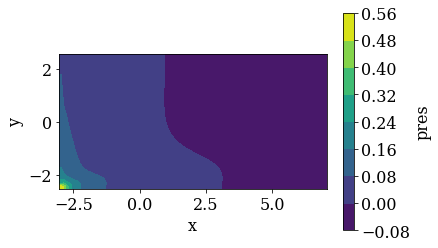

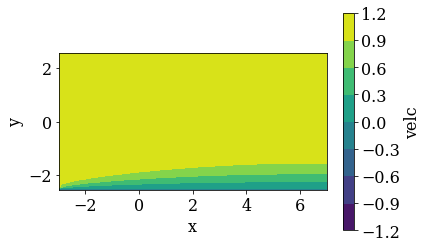

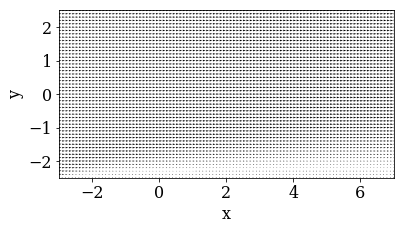

In [6]:
mae6225.io.plot_contour(gridc, 'pres')
mae6225.io.plot_contour(gridx, 'velc')
mae6225.io.plot_vector(gridx,gridy,'velc')